# Hazırlayanlar 

* ### Grup Numarası: 3
* ### Anıl Dursun İpek - 031890131
* ### Batuhan Arslandaş - 032190097

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.io
import os
import cv2
from sklearn.metrics import confusion_matrix

# Binary Classification with ANN

## Data Loading And Preparation

In [2]:
data1 = scipy.io.loadmat('data.mat')

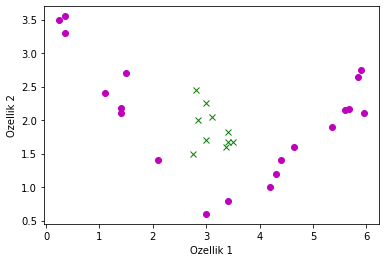

In [3]:
features = np.asarray(data1['features'])
labels = np.asarray(data1['classes'])
data_zeros_mask = np.where(labels==0)
data_zeros = features[data_zeros_mask[0],:]
plt.plot(data_zeros[:,0], data_zeros[:,1], 'mo')
data_ones_mask = np.where(labels==1)
data_ones = features[data_ones_mask[0],:]
plt.plot(data_ones[:,0], data_ones[:,1], 'gx')
plt.xlabel('Ozellik 1')
plt.ylabel('Ozellik 2')
plt.show(block=False)

In [4]:
all_data = np.concatenate((features,labels), axis=1)

In [5]:
df = pd.DataFrame(all_data, columns=["feature_1", "feature_2", "label"])

In [6]:
df.head()

,feature_1,feature_2,label
0,0.25,3.50,0.0
1,0.35,3.55,0.0
2,0.35,3.30,0.0
3,1.10,2.40,0.0
4,1.40,2.10,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  30 non-null     float64
 1   feature_2  30 non-null     float64
 2   label      30 non-null     float64
dtypes: float64(3)
memory usage: 848.0 bytes


In [8]:
df.describe()

,feature_1,feature_2,label
count,30.000000,30.000000,30.000000
mean,3.263000,2.005333,0.333333
std,1.709842,0.719635,0.479463
min,0.250000,0.600000,0.000000
25%,2.262500,1.600000,0.000000
50%,3.235000,2.025000,0.000000
75%,4.375000,2.362500,1.000000
max,5.950000,3.550000,1.000000


In [9]:
print("Total Data Length -> ", len(df))

Total Data Length ->  30


## Normalization

In [10]:
def z_normalization(features):
    # param features: Veri seti içerisindeki feature'lar.
    # function: x - mean / std
    # New mean 0
    # New std 1
    total_features = features.shape[1]
    for i in range(total_features):
        values = features.iloc[:,i].values
        mean = np.mean(values)
        std = np.std(values)
        print("Mean: ", mean , " Std: ", std)
        features.iloc[:,i] = (features.iloc[:,i].values - mean) / std

In [11]:
z_normalization(df.iloc[:,:2])

Mean:  3.263  Std:  1.6811031100639444
Mean:  2.005333333333333  Std:  0.7075390841187189


In [12]:
# Z-Normalized Data
df.head()

,feature_1,feature_2,label
0,-1.792276,2.112486,0.0
1,-1.732791,2.183154,0.0
2,-1.732791,1.829816,0.0
3,-1.286655,0.557802,0.0
4,-1.108201,0.133797,0.0


## Preprocessing for ANN

In [13]:
X = df.iloc[:,:2].values
Y = df.iloc[:,2].values.reshape(-1,1)

In [14]:
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (30, 2)
Y shape:  (30, 1)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [16]:
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (25, 2)
X test flatten (5, 2)


In [17]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (2, 25)
x test:  (2, 5)
y train:  (1, 25)
y test:  (1, 5)


## 2 Layer(1 Hidden + 1 Output) ANN Functions

In [18]:
def initialize_parameters_and_layer_sizes_NN(x_train, y_train, num_of_nodes):
    # z1 = w1 * X + b1 -> result = (3,1)
    # w1.shape = (number of nodes, number of features)
    # X.shape = (number of features, 1)
    # b1.shape = (number of features, 1)
    # A = tanh(z1)
    # z2 = w2 * A + b2 -> (1,3) * (3,1) + (1,1) =  result (1,1)
    # w2.shape = (1, number of nodes)
    # A.shape = (number of nodes, 1)
    # b.shape = (1, 1) 
    
    # Initialized with random numbers
    parameters = {"weight1": np.random.randn(num_of_nodes, x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((num_of_nodes, 1)),
                  "weight2": np.random.randn(y_train.shape[0], num_of_nodes) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

In [19]:
def sigmoid(z):
    # Activation function that converts incoming values to probabilistic values
    y_head = 1/(1+np.exp(-z))
    return y_head

In [20]:
def forward_propagation_NN(x_train, parameters):
    Z1 = np.dot(parameters["weight1"],x_train) +parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [21]:
# Compute cost
def compute_cost_NN(A2, Y):
    # Cross entropy function
    # J(Q) = sum(y* ln(yi))
    # Q -> Parameters
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

In [22]:
# Backward Propagation
def backward_propagation_NN(parameters, cache, X, Y):
    # Gradient calculation
    # Derivative calculations were made for the hidden layer and output layer by taking the derivative of the cost function.
    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

In [23]:
# update parameters
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    # Derivative values calculated according to the gradient were subtracted from the weight values and bias by 
    # multiplying the learning rate.
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

In [24]:
# prediction
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(A2.shape[1]):
        if A2[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

##### Number Of Node = 16
##### Hidden Layer = 1
##### Cost Function = Cross entropy
##### Output Node = 1
##### Output Activation Function = Sigmoid(returned probability values)
##### Input Node = 2 (Number Of Feature)
##### Metrics = Accuracy

In [25]:
# 2 - Layer neural network
def two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations):
    # Number Of Node = 16
    # Hidden Layer = 1
    # Cost Function = Cross entropy
    # Output Node = 1
    # Output Activation Function = Sigmoid(returned probability values)
    # Input Node = 2 (Number Of Feature)
    # Metrics = Accuracy
    
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    num_of_nodes = 16
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train, num_of_nodes)
    for i in range(0, num_iterations):
         # forward propagation
        A2, cache = forward_propagation_NN(x_train,parameters)
        # compute cost
        cost = compute_cost_NN(A2, y_train)
         # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
         # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 1000 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
    y_prediction_test = predict_NN(parameters,x_test)
    y_prediction_train = predict_NN(parameters,x_train)

    # Print train Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    print("----------------------------------------------------------------")
    return parameters

## Train

Cost after iteration 0: 0.221883
Cost after iteration 1000: 0.347936
Cost after iteration 2000: 0.350081
Cost after iteration 3000: 0.348134
Cost after iteration 4000: 0.347232
Cost after iteration 5000: 0.346670
Cost after iteration 6000: 0.346113
Cost after iteration 7000: 0.345395
Cost after iteration 8000: 0.344335
Cost after iteration 9000: 0.342640


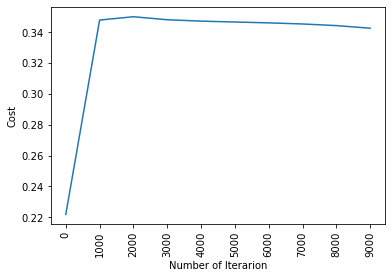

train accuracy: 68.0 %
test accuracy: 40.0 %
----------------------------------------------------------------
Cost after iteration 0: 0.222245
Cost after iteration 1000: 0.348129
Cost after iteration 2000: 0.352234
Cost after iteration 3000: 0.348654
Cost after iteration 4000: 0.346724
Cost after iteration 5000: 0.345573
Cost after iteration 6000: 0.344408
Cost after iteration 7000: 0.342758
Cost after iteration 8000: 0.340132
Cost after iteration 9000: 0.335989
Cost after iteration 10000: 0.330090
Cost after iteration 11000: 0.322866
Cost after iteration 12000: 0.314920
Cost after iteration 13000: 0.306199
Cost after iteration 14000: 0.295883


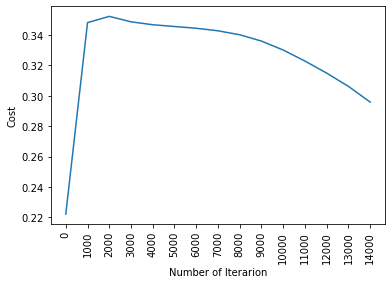

train accuracy: 64.0 %
test accuracy: 60.0 %
----------------------------------------------------------------
Cost after iteration 0: 0.223011
Cost after iteration 1000: 0.347087
Cost after iteration 2000: 0.349900
Cost after iteration 3000: 0.347878
Cost after iteration 4000: 0.346795
Cost after iteration 5000: 0.346042
Cost after iteration 6000: 0.345202
Cost after iteration 7000: 0.343949
Cost after iteration 8000: 0.341799
Cost after iteration 9000: 0.338017
Cost after iteration 10000: 0.331990
Cost after iteration 11000: 0.324041
Cost after iteration 12000: 0.315295
Cost after iteration 13000: 0.306500
Cost after iteration 14000: 0.297493
Cost after iteration 15000: 0.287049
Cost after iteration 16000: 0.271712
Cost after iteration 17000: 0.241225
Cost after iteration 18000: 0.180424
Cost after iteration 19000: 0.125927


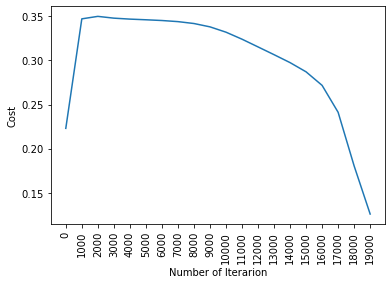

train accuracy: 96.0 %
test accuracy: 100.0 %
----------------------------------------------------------------
Cost after iteration 0: 0.223270
Cost after iteration 1000: 0.346433
Cost after iteration 2000: 0.349481
Cost after iteration 3000: 0.347600
Cost after iteration 4000: 0.346665
Cost after iteration 5000: 0.345993
Cost after iteration 6000: 0.345247
Cost after iteration 7000: 0.344246
Cost after iteration 8000: 0.342784
Cost after iteration 9000: 0.340551
Cost after iteration 10000: 0.337096
Cost after iteration 11000: 0.331939
Cost after iteration 12000: 0.324792
Cost after iteration 13000: 0.315150
Cost after iteration 14000: 0.300153
Cost after iteration 15000: 0.270720
Cost after iteration 16000: 0.220760
Cost after iteration 17000: 0.167223
Cost after iteration 18000: 0.124545
Cost after iteration 19000: 0.095477
Cost after iteration 20000: 0.075758
Cost after iteration 21000: 0.057219
Cost after iteration 22000: 0.041215
Cost after iteration 23000: 0.032061
Cost after ite

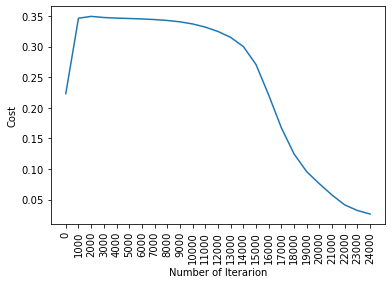

train accuracy: 100.0 %
test accuracy: 100.0 %
----------------------------------------------------------------


In [26]:
parameters_10000_iter = two_layer_neural_network(x_train, y_train, x_test,y_test, num_iterations=10000)
parameters_15000_iter = two_layer_neural_network(x_train, y_train, x_test,y_test, num_iterations=15000)
parameters_20000_iter = two_layer_neural_network(x_train, y_train, x_test,y_test, num_iterations=20000)
parameters_25000_iter = two_layer_neural_network(x_train, y_train, x_test,y_test, num_iterations=25000)

In [27]:
# most suitable parameters for 25000 iteration
parameters_25000_iter

{'weight1': array([[ 0.13709079,  0.07634009],
        [ 0.03343253,  0.71432785],
        [ 0.00351107, -0.14400943],
        [-3.01310194,  1.29613856],
        [ 0.06221652,  0.00604883],
        [ 0.0508954 , -1.16871437],
        [ 2.79555299,  0.2867342 ],
        [ 0.07291723, -0.02576765],
        [-0.11506626, -0.05706243],
        [-0.09003653, -0.03951483],
        [-0.37209492, -0.24886256],
        [ 0.25278938,  0.14414036],
        [ 0.09206701,  0.14383809],
        [-0.05501801,  0.00316196],
        [ 0.07869069,  0.09605887],
        [ 0.06267421,  0.03829695]]),
 'bias1': array([[-0.469913  ],
        [-0.43624073],
        [ 0.1723902 ],
        [ 1.88893972],
        [-0.18166757],
        [ 0.72618728],
        [ 1.57587094],
        [-0.09074449],
        [ 0.5772281 ],
        [ 0.68041705],
        [ 0.13120722],
        [-0.30913569],
        [-0.14118341],
        [ 0.16487021],
        [-0.00292056],
        [-0.0230059 ]]),
 'weight2': array([[ 0.65139726,

## Confusion Matrix

In [28]:
def conf_matrix(parameters, predictionData, trueLabel):
    # confusion matrix
    Y_pred = predict_NN(parameters, predictionData)[0]
    Y_true = trueLabel[0]
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred) 
    return confusion_mtx

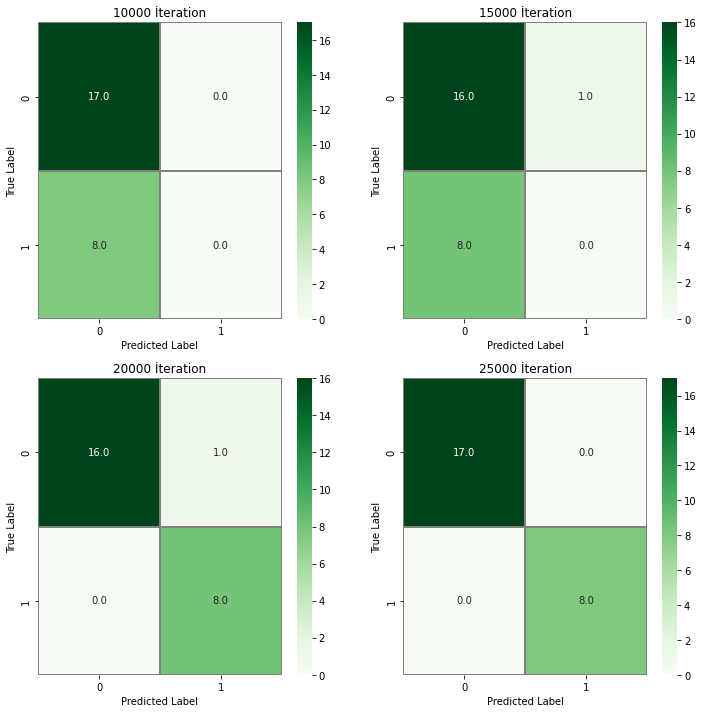

In [29]:
#plot_confusion_matrix(fold_path : str, index: int , title : str, realValue: str):
# 10000 İteration
conf_10000 = conf_matrix(parameters_10000_iter, x_train, y_train)
# 15000 İteration
conf_15000 = conf_matrix(parameters_15000_iter, x_train, y_train)
# 20000 İteration
conf_20000 = conf_matrix(parameters_20000_iter, x_train, y_train)
# 25000 İteration
conf_25000 = conf_matrix(parameters_25000_iter, x_train, y_train)


# plot the confusion matrix
f,axes = plt.subplots(2,2, figsize=(12,12))
sns.heatmap(conf_10000, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=axes[0,0])
axes[0,0].set_title("10000 İteration")
axes[0,0].set_xlabel("Predicted Label")
axes[0,0].set_ylabel("True Label")

sns.heatmap(conf_15000, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=axes[0,1])
axes[0,1].set_title("15000 İteration")
axes[0,1].set_xlabel("Predicted Label")
axes[0,1].set_ylabel("True Label")

sns.heatmap(conf_20000, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=axes[1,0])
axes[1,0].set_title("20000 İteration")
axes[1,0].set_xlabel("Predicted Label")
axes[1,0].set_ylabel("True Label")

sns.heatmap(conf_25000, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=axes[1,1])
axes[1,1].set_title("25000 İteration")
axes[1,1].set_xlabel("Predicted Label")
axes[1,1].set_ylabel("True Label")
plt.show()

## 5x5 Cross Validation Results with 10000 iterations

In [30]:
x = np.concatenate((x_train,x_test), axis=1)
x.shape

(2, 30)

In [31]:
y = np.concatenate((y_train,y_test), axis=1)
y.shape

(1, 30)

TRAIN: [ 0  1  3  5  6  8  9 10 12 13 14 15 16 17 18 19 21 22 23 24 26 27 28 29] TEST: [ 2  4  7 11 20 25]
Cost after iteration 0: 0.229334
Cost after iteration 1000: 0.342992
Cost after iteration 2000: 0.329775
Cost after iteration 3000: 0.315886
Cost after iteration 4000: 0.287100
Cost after iteration 5000: 0.224807
Cost after iteration 6000: 0.160231
Cost after iteration 7000: 0.117061
Cost after iteration 8000: 0.090668
Cost after iteration 9000: 0.073141


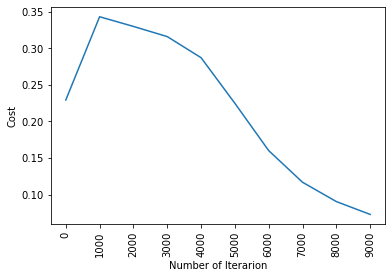

train accuracy: 100.0 %
test accuracy: 83.33333333333334 %
----------------------------------------------------------------
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 14 15 17 18 20 21 22 25 26 27 28 29] TEST: [ 5 13 16 19 23 24]
Cost after iteration 0: 0.201603
Cost after iteration 1000: 0.344607
Cost after iteration 2000: 0.353464
Cost after iteration 3000: 0.352737
Cost after iteration 4000: 0.351281
Cost after iteration 5000: 0.347908
Cost after iteration 6000: 0.334764
Cost after iteration 7000: 0.290706
Cost after iteration 8000: 0.225981
Cost after iteration 9000: 0.174142


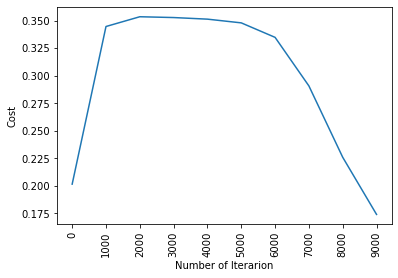

train accuracy: 95.83333333333333 %
test accuracy: 100.0 %
----------------------------------------------------------------
TRAIN: [ 0  2  3  4  5  6  7  8 10 11 12 13 16 19 20 21 22 23 24 25 26 27 28 29] TEST: [ 1  9 14 15 17 18]
Cost after iteration 0: 0.202298
Cost after iteration 1000: 0.338966
Cost after iteration 2000: 0.344952
Cost after iteration 3000: 0.341731
Cost after iteration 4000: 0.339728
Cost after iteration 5000: 0.337580
Cost after iteration 6000: 0.333289
Cost after iteration 7000: 0.324185
Cost after iteration 8000: 0.309612
Cost after iteration 9000: 0.293015


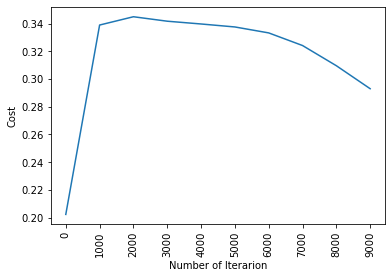

train accuracy: 70.83333333333333 %
test accuracy: 50.0 %
----------------------------------------------------------------
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 23 24 25 26] TEST: [ 6 21 22 27 28 29]
Cost after iteration 0: 0.262450
Cost after iteration 1000: 0.345506
Cost after iteration 2000: 0.338761
Cost after iteration 3000: 0.334639
Cost after iteration 4000: 0.332604
Cost after iteration 5000: 0.330513
Cost after iteration 6000: 0.327507
Cost after iteration 7000: 0.323028
Cost after iteration 8000: 0.316973
Cost after iteration 9000: 0.309993


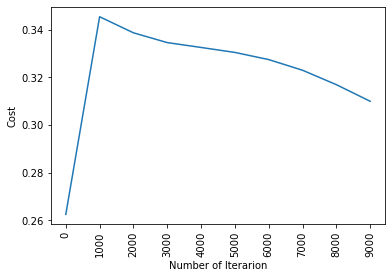

train accuracy: 58.33333333333333 %
test accuracy: 66.66666666666667 %
----------------------------------------------------------------
TRAIN: [ 1  2  4  5  6  7  9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 27 28 29] TEST: [ 0  3  8 10 12 26]
Cost after iteration 0: 0.260527
Cost after iteration 1000: 0.348541
Cost after iteration 2000: 0.344268
Cost after iteration 3000: 0.340429
Cost after iteration 4000: 0.338397
Cost after iteration 5000: 0.336036
Cost after iteration 6000: 0.332057
Cost after iteration 7000: 0.325412
Cost after iteration 8000: 0.316387
Cost after iteration 9000: 0.306854


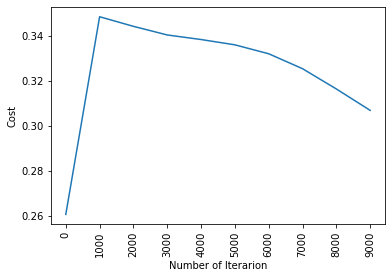

train accuracy: 66.66666666666667 %
test accuracy: 50.0 %
----------------------------------------------------------------


In [32]:
features = np.asarray(data1['features'])
labels = np.asarray(data1['classes'])
points = []
for i in range(features.shape[0]):
    points.append((features[i,:][:],labels[i,0]))
points = np.asarray(points) 
fold = 5
kf = KFold(n_splits=fold, random_state=None, shuffle=True)
for train_index, test_index in kf.split(points):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x[:,train_index], x[:, test_index]
    y_train, y_test = y[:,train_index], y[:,test_index]
    #X_train, X_test = points[train_index,0], points[test_index,0]
    #y_train, y_test = points[train_index,1], points[test_index,1]
    two_layer_neural_network(X_train, y_train, X_test, y_test, num_iterations=10000)

## Result
1. Training was done for 10000, 15000, 20000, 25000 iterations.
1. The increase in the Number of Iterations caused a decrease in the loss function.
1. With 25000 iterations, 100 accuracy was achieved and the classes were successfully predicted.

# Multi-Class Classification With ANN

In [33]:
train_image_path = "free-spoken-digit-dataset-master/training-spectrograms/"
test_image_path = "free-spoken-digit-dataset-master/testing-spectrograms/"

In [34]:
ex_img = cv2.imread("free-spoken-digit-dataset-master/training-spectrograms/0_george_1.png", cv2.IMREAD_GRAYSCALE)
print("ex_img.shape: ", ex_img.shape)

ex_img.shape:  (64, 64)


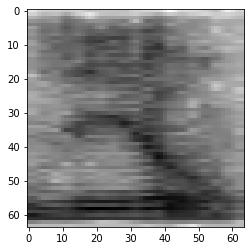

In [35]:
plt.imshow(ex_img, cmap="gray")

In [36]:
train_images_dframe = pd.DataFrame(columns=["classID" if x == 0 else "pixel" + str(x) for x in range(64*64+1)])
for spectrogram_path in os.listdir(train_image_path):
    img = cv2.imread(train_image_path + spectrogram_path, cv2.IMREAD_GRAYSCALE)
    classID = spectrogram_path[0]
    classID = np.array([int(classID)])
    img_r = img.flatten()
    new_df_row = np.concatenate((classID, img_r),axis=0).reshape(1,-1)
    #print(new_df_row[0])
    train_images_dframe = train_images_dframe.append(pd.DataFrame(new_df_row.reshape(1,-1), columns=list(train_images_dframe)), ignore_index=True)

In [37]:
train_images_dframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Columns: 4097 entries, classID to pixel4096
dtypes: object(4097)
memory usage: 7.5+ MB


In [38]:
train_images_dframe.head()

,classID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
0,0,193,193,190,179,172,171,171,172,172,...,154,153,153,153,153,154,155,156,157,157
1,0,190,190,186,181,178,178,178,178,186,...,177,175,174,174,174,174,175,176,176,176
2,0,147,147,159,186,206,203,190,178,177,...,131,131,131,136,141,143,144,147,147,147
3,0,188,188,188,184,179,177,182,195,209,...,167,167,166,166,166,166,166,167,167,167
4,0,147,147,147,155,163,168,174,192,211,...,127,129,137,144,146,146,145,144,144,144


In [39]:
test_images_dframe = pd.DataFrame(columns=["classID" if x == 0 else "pixel" + str(x) for x in range(64*64+1)])
for spectrogram_path in os.listdir(test_image_path):
    img = cv2.imread(test_image_path + spectrogram_path, cv2.IMREAD_GRAYSCALE)
    classID = spectrogram_path[0]
    classID = np.array([int(classID)])
    img_r = img.flatten()
    new_df_row = np.concatenate((classID, img_r),axis=0).reshape(1,-1)
    test_images_dframe = test_images_dframe.append(pd.DataFrame(new_df_row.reshape(1,-1), columns=list(test_images_dframe)), ignore_index=True)

In [40]:
test_images_dframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 4097 entries, classID to pixel4096
dtypes: object(4097)
memory usage: 1.9+ MB


In [41]:
test_images_dframe.head()

,classID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
0,0,210,210,210,210,210,209,207,206,205,...,191,192,193,194,195,195,195,195,195,195
1,0,171,171,161,139,128,136,154,165,158,...,131,138,140,141,142,143,141,139,138,138
2,0,126,126,131,144,151,156,168,175,174,...,135,142,145,147,149,150,152,154,155,155
3,0,112,112,112,113,118,121,123,123,120,...,68,66,66,66,66,68,69,69,69,69
4,0,161,161,161,162,163,163,165,166,168,...,135,137,139,137,131,126,121,119,119,119


In [42]:
# Normalization
test_images_dframe.iloc[:,1:]  = test_images_dframe.iloc[:,1:] / 255
train_images_dframe.iloc[:,1:] = train_images_dframe.iloc[:,1:] / 255

In [43]:
train_images_dframe.head()

,classID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel4087,pixel4088,pixel4089,pixel4090,pixel4091,pixel4092,pixel4093,pixel4094,pixel4095,pixel4096
0,0,0.756863,0.756863,0.745098,0.701961,0.67451,0.670588,0.670588,0.67451,0.67451,...,0.603922,0.6,0.6,0.6,0.6,0.603922,0.607843,0.611765,0.615686,0.615686
1,0,0.745098,0.745098,0.729412,0.709804,0.698039,0.698039,0.698039,0.698039,0.729412,...,0.694118,0.686275,0.682353,0.682353,0.682353,0.682353,0.686275,0.690196,0.690196,0.690196
2,0,0.576471,0.576471,0.623529,0.729412,0.807843,0.796078,0.745098,0.698039,0.694118,...,0.513725,0.513725,0.513725,0.533333,0.552941,0.560784,0.564706,0.576471,0.576471,0.576471
3,0,0.737255,0.737255,0.737255,0.721569,0.701961,0.694118,0.713725,0.764706,0.819608,...,0.654902,0.654902,0.65098,0.65098,0.65098,0.65098,0.65098,0.654902,0.654902,0.654902
4,0,0.576471,0.576471,0.576471,0.607843,0.639216,0.658824,0.682353,0.752941,0.827451,...,0.498039,0.505882,0.537255,0.564706,0.572549,0.572549,0.568627,0.564706,0.564706,0.564706


In [44]:
x_train = train_images_dframe.iloc[:,1:].values.reshape(-1,64,64,1)
x_test = test_images_dframe.iloc[:,1:].values.reshape(-1,64,64,1)
y_train = train_images_dframe.iloc[:,0].values
y_test = test_images_dframe.iloc[:,0].values

In [45]:
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (240, 64, 64, 1)
x test:  (60, 64, 64, 1)
y train:  (240,)
y test:  (60,)
